Data Preparation

In [13]:
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession

config = ConfigProto()
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)

c:\Users\User\anaconda3\lib\site-packages\tensorflow\python\client\session.py:1768: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


In [14]:
import pandas as pd
import string
import nltk
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\User\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\User\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [15]:
abbreviation_map = {
    "u": "you",
    "btw": "by the way",
    "omg": "oh my god",
    "idk": "I don't know",
    "lol": "laughing out loud",
    "pls": "please",
    "thx": "thanks",
    "im": "I am",
    "dont": "do not",
    "cant": "cannot",
    "wont": "will not",
    # Add more as needed
}

In [16]:
#Changed the 'train_data' into 'raw_data' and changed 'test_data' into 'answer_data'

labelled_data = pd.read_json('train.json')
answer_data = pd.read_json('test.json')

print(labelled_data.head())
print(answer_data.head())

raw_labels = labelled_data['sentiments']

                                             reviews  sentiments
0  I bought this belt for my daughter in-law for ...           1
1  The size was perfect and so was the color.  It...           1
2  Fits and feels good, esp. for doing a swim rac...           1
3  These socks are absolutely the best. I take pi...           1
4  Thank you so much for the speedy delivery they...           1
                                             reviews
0  I bought 2 sleepers.  sleeper had holes in the...
1  I dare say these are just about the sexiest th...
2  everything about the transaction (price, deliv...
3  Not bad for just a shirt.  Very durable, and m...
4  These are truly wrinkle free and longer than t...


In [17]:
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

In [18]:
def clean_text(text):
    # Convert to lowercase
    text = text.lower()
    # Expand abbreviations
    text = ' '.join([abbreviation_map.get(word, word) for word in text.split()])
    # Remove punctuation
    text = text.translate(str.maketrans('', '', string.punctuation))
    # Remove stopwords and lemmatize
    text = ' '.join([lemmatizer.lemmatize(word) for word in text.split() if word not in stop_words])
    return text

In [19]:
labelled_data['cleaned_reviews'] = labelled_data['reviews'].apply(clean_text)
answer_data['cleaned_reviews'] = answer_data['reviews'].apply(clean_text)

In [20]:
print(labelled_data.head())

                                             reviews  sentiments  \
0  I bought this belt for my daughter in-law for ...           1   
1  The size was perfect and so was the color.  It...           1   
2  Fits and feels good, esp. for doing a swim rac...           1   
3  These socks are absolutely the best. I take pi...           1   
4  Thank you so much for the speedy delivery they...           1   

                                     cleaned_reviews  
0         bought belt daughter inlaw christmas loved  
1            size perfect color looked like web page  
2  fit feel good esp swim race highly recommend c...  
3  sock absolutely best take pilate class hot foo...  
4  thank much speedy delivery came time rehearsal...  


In [21]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Tokenization: Basically divides the sentences into segments
tokenizer = Tokenizer()
tokenizer.fit_on_texts(labelled_data['cleaned_reviews']) #Indexes each token (each word is given a number). Index = 0 is for padding

# Convert text to sequences
raw_sequences = tokenizer.texts_to_sequences(labelled_data['cleaned_reviews'])
answer_sequences = tokenizer.texts_to_sequences(answer_data['cleaned_reviews'])

# Padding sequences
max_length = max(max(len(seq) for seq in raw_sequences), max(len(seq) for seq in answer_sequences)) #Finding the maximum sequence length from both the raw_data and answer_data
raw_final = pad_sequences(raw_sequences, maxlen=max_length, padding='post') #standardize the array
answer_final = pad_sequences(answer_sequences, maxlen=max_length, padding='post')

# Display the shape of padded sequences
print(f'Train padded shape: {raw_final.shape}')
print(f'Test padded shape: {answer_final.shape}')

Train padded shape: (7401, 518)
Test padded shape: (1851, 518)


In [22]:
raw_final

array([[  15,  255,  185, ...,    0,    0,    0],
       [   4,   45,   22, ...,    0,    0,    0],
       [   8,   36,    9, ...,    0,    0,    0],
       ...,
       [1257,  140,   25, ...,    0,    0,    0],
       [ 144,  829,  377, ...,    0,    0,    0],
       [ 231,  880,   83, ...,    0,    0,    0]])

In [23]:
answer_final

array([[  15,  122, 4282, ...,    0,    0,    0],
       [2720,   80, 4719, ...,    0,    0,    0],
       [ 176, 1411,   17, ...,    0,    0,    0],
       ...,
       [  18,  116,  213, ...,    0,    0,    0],
       [ 185,   11,   58, ...,    0,    0,    0],
       [1026,  652,  156, ...,    0,    0,    0]])

In [24]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

# Load GloVe word embeddings (download and extract glove.6B.100d.txt)
embedding_dim = 100 #as vectors of n real numbers
glove_file = 'C:/Users/User/Downloads/Telegram Desktop/glove.6B/glove.6B.100d.txt' #change this to your glove path
embeddings_index = {}

with open(glove_file, encoding='utf-8') as f:
    for line in f:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embeddings_index[word] = coefs

print(f'Loaded {len(embeddings_index)} word vectors from GloVe.')


Loaded 400000 word vectors from GloVe.


In [25]:
# Prepare the embedding matrix
vocab_size = len(tokenizer.word_index) + 1  # +1 for padding token
embedding_matrix = np.zeros((vocab_size, embedding_dim))

# Map the words in the tokenizer's vocabulary to GloVe vectors
for word, i in tokenizer.word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector  # Words found in GloVe will use pretrained vectors

# Check the embedding matrix shape
print(f'Embedding matrix shape: {embedding_matrix.shape}')

Embedding matrix shape: (14876, 100)


c:\Users\User\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
c:\Users\User\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


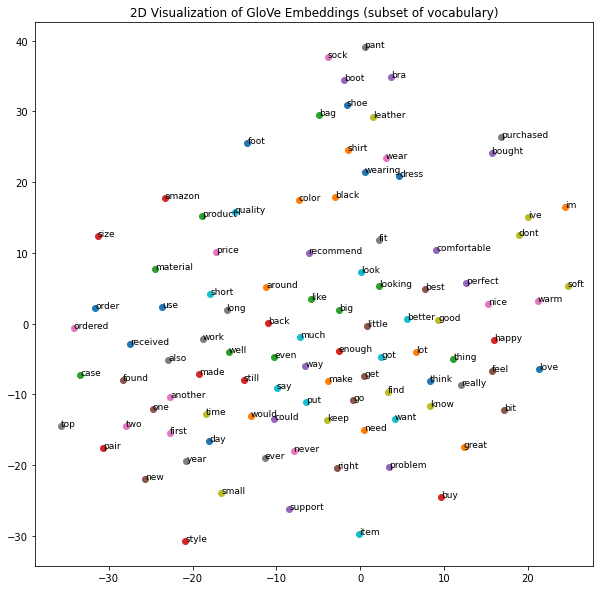

In [26]:
# Visualize the GloVe embeddings with t-SNE

# Step 1: Select a subset of words from the vocabulary (e.g., the first 100 words)
word_subset = list(tokenizer.word_index.keys())[:100]
word_vectors = np.array([embedding_matrix[tokenizer.word_index[word]] for word in word_subset])

# Step 2: Apply t-SNE to reduce dimensionality to 2D
tsne = TSNE(n_components=2, random_state=42)
word_vecs_2d = tsne.fit_transform(word_vectors)

# Step 3: Plot the words in 2D space
plt.figure(figsize=(10, 10))
for i, word in enumerate(word_subset):
    plt.scatter(word_vecs_2d[i, 0], word_vecs_2d[i, 1])
    plt.annotate(word, (word_vecs_2d[i, 0], word_vecs_2d[i, 1]), fontsize=9)
plt.title("2D Visualization of GloVe Embeddings (subset of vocabulary)")
plt.show()

In [27]:
max_length

518

In [28]:
#train test split the raw data
from sklearn.model_selection import train_test_split
labelled_train, labelled_test, label_train, label_test = train_test_split(
    raw_final, raw_labels, test_size=0.2, random_state=42)

In [32]:
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM, Bidirectional, Dropout


# Define your model
model = Sequential()
model.add(Embedding(vocab_size, 100, weights=[embedding_matrix], input_length=max_length, trainable=True))
#CuDNN has very strict requirements to be able to use GPU, im putting it here to show the requirements, some of them are already default settings though
model.add(Bidirectional(LSTM(64,
                             activation='tanh',  # Default settings, to show
                             recurrent_activation='sigmoid',  # Default
                             return_sequences=True,  # Must be set to true for the first layer
                             recurrent_dropout=0,  # Must be 0 for cuDNN
                             unroll=False,  # Must be False for cuDNN
                             use_bias=True)))  # Default is True
model.add(Dropout(0.5))
model.add(Bidirectional(LSTM(4,
                             activation='tanh',  # Default settings, to show
                             recurrent_activation='sigmoid',  # Default
                             return_sequences=False,  # Set appropriately, not Default
                             recurrent_dropout=0,  # Must be 0 for cuDNN
                             unroll=False,  # Must be False for cuDNN
                             use_bias=True)))  # Default is True
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])

# Print the model summary
model.summary()

snn_model_history = model.fit(labelled_train, label_train, batch_size=256, epochs=20, verbose=1, validation_split=0.2)

print("Test Accuracy and Loss")
loss, acc = model.evaluate(labelled_test, label_test)

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 518, 100)          1487600   
                                                                 
 bidirectional_4 (Bidirectio  (None, 518, 128)         84480     
 nal)                                                            
                                                                 
 dropout_4 (Dropout)         (None, 518, 128)          0         
                                                                 
 bidirectional_5 (Bidirectio  (None, 8)                4256      
 nal)                                                            
                                                                 
 dropout_5 (Dropout)         (None, 8)                 0         
                                                                 
 dense_2 (Dense)             (None, 1)                